In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import expon

def logspace_sub(a, b):
    """Compute log(exp(a) - exp(b)) in a numerically stable way."""
    return a + np.log1p(-np.exp(b - a))

def dtexp(x, rate=1, lower_trunc=None, upper_trunc=None):
    """Calculate the log of the truncated exponential distribution."""
    log_dens = expon.logpdf(x, scale=1/rate)
    if lower_trunc is not None and upper_trunc is not None:
        log_dens -= logspace_sub(expon.logsf(lower_trunc, scale=1/rate), expon.logsf(upper_trunc, scale=1/rate))
    return log_dens

def dtexp_norm(x, rate=1):
    """Calculate the log of the non-truncated exponential distribution."""
    return expon.logpdf(x, scale=1/rate)

def Simple_Pulse_Segments_fn(input_df, truncation=False, lower_trunc=None, upper_trunc=None, tm_lower=10, tm_upper=1000):
    Segments = input_df
    
    if truncation:
        l = Segments['length_cM'][(Segments['length_cM'] >= lower_trunc) & (Segments['length_cM'] <= upper_trunc)]
    else:
        l = Segments['length_cM'][Segments['length_cM'] > 0]
    
    l = l.values / 100  # Convert to the same scale as in the R code
    
    try:
        if truncation:
            def f(par):
                return -np.sum(dtexp(l, rate=par[0], lower_trunc=lower_trunc/100, upper_trunc=upper_trunc/100))
        else:
            def f(par):
                return -np.sum(dtexp_norm(l, rate=par[0]))
        
        res = minimize(f, x0=[500], bounds=[(tm_lower, tm_upper)], method='L-BFGS-B')
        tm = res.x[0]
        
        if truncation:
            hist, bin_edges = np.histogram(l * 100, bins=500)
            mids = (bin_edges[:-1] + bin_edges[1:]) / 2
            f_predict = dtexp(mids / 100, rate=tm, lower_trunc=lower_trunc/100, upper_trunc=upper_trunc/100)
            f_predict_df = pd.DataFrame({'seg_len_M': mids, 'log_dens': f_predict})
        else:
            hist, bin_edges = np.histogram(l * 100, bins=500)
            mids = (bin_edges[:-1] + bin_edges[1:]) / 2
            f_predict = dtexp_norm(mids / 100, rate=tm)
            f_predict_df = pd.DataFrame({'seg_len_M': mids, 'log_dens': f_predict})
        
        return {
            'result': res,
            'params_df': pd.DataFrame({'tm': [tm], 'll_sp': [-res.fun], 'lower_trunc': [lower_trunc], 'upper_trunc': [upper_trunc]}),
            'segments': l,
            'f_predict': f_predict_df
        }
    except Exception as e:
        return {
            'error': str(e),
            'params_df': pd.DataFrame({'tm': [None], 'll_sp': [None], 'lower_trunc': [lower_trunc], 'upper_trunc': [upper_trunc]}),
            'segments': l,
            'f_predict': None
        }
import numpy as np

def get_ci_dating(est, n_data):
    org = est
    lwr_approx = est * (1 - (1.96 / np.sqrt(n_data)))
    upr_approx = est * (1 + (1.96 / np.sqrt(n_data)))
    param_ci = (org, lwr_approx, upr_approx)
    return param_ci





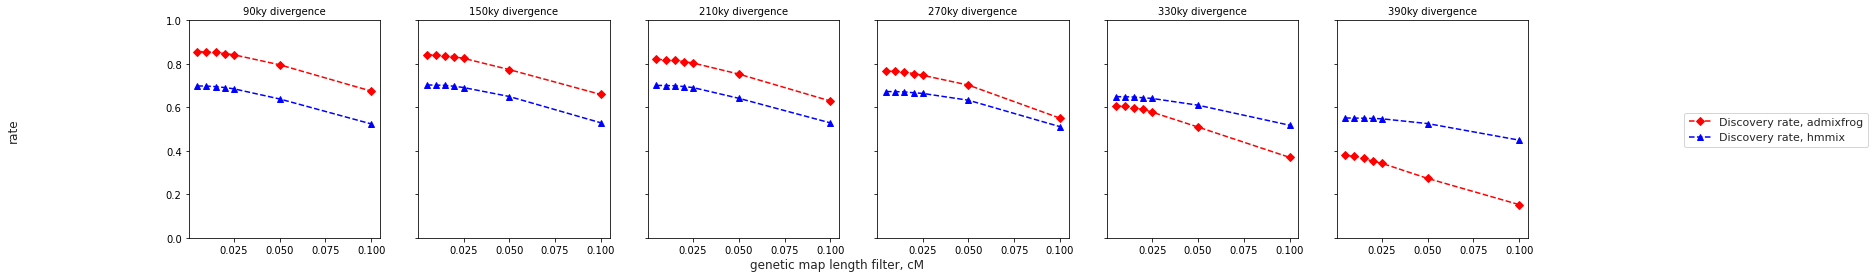

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
s = "den"

fig, axes = plt.subplots(1,6, figsize=(24,4), sharex=True, sharey=True)
colors = {'frog_AA': 'red', 'frog_d3_AA': 'red','frog_den_AA':'red', 'frog_d3':"pink", 'frog_den': 'pink', 'hmm': 'blue'}
shapes = {'frog_AA': 'o', 'frog_d3_AA':'s','frog_den_AA':'D', 'frog_d3': 's', 'frog_den': 'D', 'hmm': '^'}
linestyles = {3: 'dashdot', 4: 'dashed', 5: 'dotted', 6: 'solid'}
for panel, t in zip(range(0,6), ['90','150','210','270', '330','390']):
    import pandas as pd
    #sensi 
    # hit + hit_wrong > hit_all, as hit_all does not include overlapping part in a  diploid genome, but hit wrong can are hap.
    sum_ = pd.DataFrame(columns = ['called','hit','hit_wrong','hit_all_source','hit_none_source','simulation','simulation_all_source','min_map','min_match','ind','source','method'])
    for i in range(0,15):
        df = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.ind{i}.sums", sep = '\s+', 
                         names =  ['called','hit','hit_wrong','hit_all_source','hit_none_source','simulation',
                                   'simulation_all_source','simulation_filter_by_len','min_map','min_match','ind','source','method'],
                         dtype={'ind':int})
        df = df[['called','hit','hit_wrong','hit_all_source','hit_none_source','simulation','simulation_all_source','simulation_filter_by_len','min_map','min_match','ind','source','method']]
        #df = df[(df['min_match'] >= 3)].reset_index(drop = True)
        sum_ = pd.concat([sum_,df])
        sum_['simulation'] = sum_['simulation'].astype(float)
        sum_ = sum_[(sum_['min_match'] == 4) | (sum_['method']=="frog_den_AA") | (sum_['method']=="frog_AA") | (sum_['method']=="frog_den")]
    sum_ = sum_[(sum_['min_match'] == 4) | (sum_['method']!="")]
    sum_ = sum_[(sum_['min_match'] == 4) | (sum_['method']!="hmm")]
    sum_1 = sum_[sum_['ind']<=4].reset_index(drop = True)
    sum_2 = sum_[(sum_['ind']>4) & (sum_['ind']<=9)].reset_index(drop = True)
    sum_3 = sum_[sum_['ind']>9].reset_index(drop = True)
    len_ =  pd.DataFrame(columns = ['len','source','method','ind'])
    len_frog_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.0", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_1 = len_frog_1[['len','source','method','ind']]
    len_frog_1['method'] = "frog "+len_frog_1['method'].astype(str)
    len_frog_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.1", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_2 = len_frog_2[['len','source','method','ind']]
    len_frog_2['method'] = "frog "+len_frog_2['method'].astype(str)
    len_frog_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.2", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_3 = len_frog_3[['len','source','method','ind']]
    len_frog_3['method'] = "frog "+len_frog_3['method'].astype(str)
    len_hmm_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.0", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_1 = len_hmm_1[['len','source','ind']]
    len_hmm_1['method'] = "hmm"
    len_hmm_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.1", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_2 = len_hmm_2[['len','source','ind']]
    len_hmm_2['method'] = "hmm"
    len_hmm_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.2", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_3 = len_hmm_3[['len','source','ind']]
    len_hmm_3['method'] = "hmm"
    len_true_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.0", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_1['len'] = (len_true_1['end'] - len_true_1['start']) *1.25e-6
    len_true_1 = len_true_1[['len','source','ind']]
    len_true_1['method'] = "simulation"
    len_true_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.1", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_2['len'] = (len_true_2['end'] - len_true_2['start']) *1.25e-6
    len_true_2 = len_true_2[['len','source','ind']]
    len_true_2['method'] = "simulation"
    len_true_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.2", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_3['len'] = (len_true_3['end'] - len_true_3['start']) *1.25e-6
    len_true_3 = len_true_3[['len','source','ind']]
    len_true_3['method'] = "simulation"
    len_1 = pd.concat([len_frog_1,len_hmm_1,len_true_1])
    len_2 = pd.concat([len_frog_2,len_hmm_2,len_true_2])
    len_3 = pd.concat([len_frog_3,len_hmm_3,len_true_3])
    #for the same min_map. min_match, pop, source, method, calculate the sum of called, the sum of hit, the sum of simulation
    sum_1 = sum_1.groupby(['min_map','min_match','source','method']).agg({'called':'sum','hit':'sum','hit_wrong':'sum','hit_all_source':'sum','hit_none_source':'sum','simulation':'sum','simulation_all_source':'sum'}).reset_index()
    sum_2 = sum_2.groupby(['min_map','min_match','source','method']).agg({'called':'sum','hit':'sum','hit_wrong':'sum','hit_all_source':'sum','hit_none_source':'sum','simulation':'sum','simulation_all_source':'sum'}).reset_index()
    sum_3 = sum_3.groupby(['min_map','min_match','source','method']).agg({'called':'sum','hit':'sum','hit_wrong':'sum','hit_all_source':'sum','hit_none_source':'sum','simulation':'sum','simulation_all_source':'sum'}).reset_index()
    sum_1['accuracy'] = sum_1['hit']/sum_1['called']
    sum_1['sensitivity'] = sum_1['hit']/sum_1['simulation']
    sum_1['mis_assign'] = sum_1['hit_wrong']/sum_1['called']
    sum_1['false_positive'] = sum_1['hit_none_source']/sum_1['called']
    sum_2['accuracy'] = sum_2['hit']/sum_2['called']
    sum_2['sensitivity'] = sum_2['hit']/sum_2['simulation']
    sum_2['mis_assign'] = sum_2['hit_wrong']/sum_2['called']
    sum_2['false_positive'] = sum_2['hit_none_source']/sum_2['called']
    sum_3['accuracy'] = sum_3['hit']/sum_3['called']
    sum_3['sensitivity'] = sum_3['hit']/sum_3['simulation']
    sum_3['mis_assign'] = sum_3['hit_wrong']/sum_3['called']
    sum_3['false_positive'] = sum_3['hit_none_source']/sum_3['called']
    sum_1nea = sum_1[sum_1['source']=='nea']
    sum_1den = sum_1[sum_1['source']=='den']
    sum_2nea = sum_2[sum_2['source']=='nea']
    sum_2den = sum_2[sum_2['source']=='den']
    sum_3nea = sum_3[sum_3['source']=='nea']
    sum_3den = sum_3[sum_3['source']=='den']
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    if s == "nea":
        dfs = [sum_1nea, sum_2nea, sum_3nea]
    elif s == "den":
        dfs = [sum_1den, sum_2den, sum_3den]
    sns.set(style="whitegrid")


    # Plot data
    df = dfs[1] #15kya
    #xxx = 1
    s_time = "15kya"
    for (method, min_match), group in df.groupby(['method', 'min_match']):
        color = colors.get(method, 'black')
        shape = shapes.get(method, 'o')
        linestyle = linestyles.get(min_match, 'solid')
        
        #Plot accuracy
        if method == "hmm":
            axes[panel].plot(group['min_map'], group['sensitivity'], label=f'Discovery rate, hmmix', 
                color="blue", marker=shape, linestyle="dashed")
        elif method == "frog_den_AA":
            axes[panel].plot(group['min_map'], group['sensitivity'], label=f'Discovery rate, admixfrog', 
                color="red", marker=shape, linestyle="dashed")

        axes[panel].set_title(f"{t}ky divergence", fontsize = 10)
        axes[panel].set_ylim(0, 1)
            
    # Add a single title, shared x and y labels
    if s == "nea":
        ss = "Neanderthal segments"
    elif s =="den":
        ss = "Denisovan Segments"
    #fig.suptitle(f'Accuracy / Sensitivity For {ss}'+f', {t} kya divergence, '+f"sampled at {s_time}", fontsize=16)
    fig.supxlabel('genetic map length filter, cM', fontsize=12)
    fig.supylabel('rate', fontsize=12)
    # Combine all legends into one
handles, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)


plt.show()


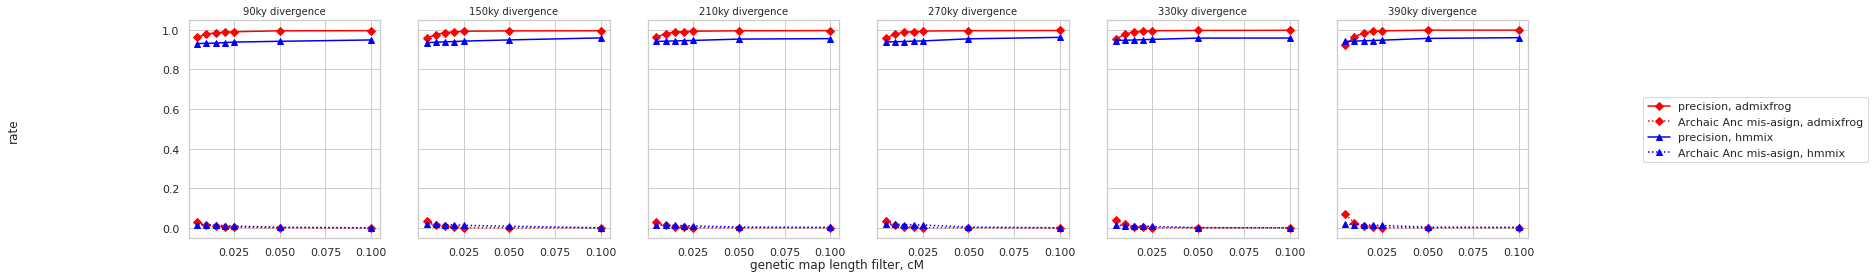

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
s = "den"


fig, axes = plt.subplots(1,6, figsize=(24,4), sharex=True, sharey=True)
colors = {'frog_AA': 'red', 'frog_d3_AA': 'red','frog_den_AA':'red', 'frog_d3':"pink", 'frog_den': 'pink', 'hmm': 'blue'}
shapes = {'frog_AA': 'o', 'frog_d3_AA':'s','frog_den_AA':'D', 'frog_d3': 's', 'frog_den': 'D', 'hmm': '^'}
linestyles = {3: 'dashdot', 4: 'dashed', 5: 'dotted', 6: 'solid'}
for panel, t in zip(range(0,6), ['90','150','210','270', '330','390']):
    import pandas as pd
    #sensi 
    # hit + hit_wrong > hit_all, as hit_all does not include overlapping part in a  diploid genome, but hit wrong can are hap.
    sum_ = pd.DataFrame(columns = ['called','hit','hit_wrong','hit_all_source','hit_none_source','simulation','simulation_all_source','min_map','min_match','ind','source','method'])
    for i in range(0,15):
        df = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.ind{i}.sums", sep = '\s+', names =  ['called','hit','hit_wrong','hit_all_source','hit_none_source','simulation','simulation_all_source','simulation_filter_by_len','min_map','min_match','ind','source','method'])
        df = df[['called','hit','hit_wrong','hit_all_source','hit_none_source','simulation','simulation_all_source','simulation_filter_by_len','min_map','min_match','ind','source','method']]
        #df = df[(df['min_match'] >= 3)].reset_index(drop = True)
        sum_ = pd.concat([sum_,df])
        sum_['simulation'] = sum_['simulation'].astype(float)
        sum_ = sum_[(sum_['min_match'] == 4) | (sum_['method']=="frog_den_AA") | (sum_['method']=="frog_AA") | (sum_['method']=="frog_den")]
    sum_ = sum_[(sum_['min_match'] == 4) | (sum_['method']!="")]
    sum_ = sum_[(sum_['min_match'] == 4) | (sum_['method']!="hmm")]
    sum_1 = sum_[sum_['ind']<=4].reset_index(drop = True)
    sum_2 = sum_[(sum_['ind']>4) & (sum_['ind']<=9)].reset_index(drop = True)
    sum_3 = sum_[sum_['ind']>9].reset_index(drop = True)
    len_ =  pd.DataFrame(columns = ['len','source','method','ind'])
    len_frog_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.0", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_1 = len_frog_1[['len','source','method','ind']]
    len_frog_1['method'] = "frog "+len_frog_1['method'].astype(str)
    len_frog_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.1", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_2 = len_frog_2[['len','source','method','ind']]
    len_frog_2['method'] = "frog "+len_frog_2['method'].astype(str)
    len_frog_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.2", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_3 = len_frog_3[['len','source','method','ind']]
    len_frog_3['method'] = "frog "+len_frog_3['method'].astype(str)
    len_hmm_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.0", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_1 = len_hmm_1[['len','source','ind']]
    len_hmm_1['method'] = "hmm"
    len_hmm_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.1", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_2 = len_hmm_2[['len','source','ind']]
    len_hmm_2['method'] = "hmm"
    len_hmm_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.2", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_3 = len_hmm_3[['len','source','ind']]
    len_hmm_3['method'] = "hmm"
    len_true_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.0", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_1['len'] = (len_true_1['end'] - len_true_1['start']) *1.25e-6
    len_true_1 = len_true_1[['len','source','ind']]
    len_true_1['method'] = "simulation"
    len_true_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.1", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_2['len'] = (len_true_2['end'] - len_true_2['start']) *1.25e-6
    len_true_2 = len_true_2[['len','source','ind']]
    len_true_2['method'] = "simulation"
    len_true_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.2", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_3['len'] = (len_true_3['end'] - len_true_3['start']) *1.25e-6
    len_true_3 = len_true_3[['len','source','ind']]
    len_true_3['method'] = "simulation"
    len_1 = pd.concat([len_frog_1,len_hmm_1,len_true_1])
    len_2 = pd.concat([len_frog_2,len_hmm_2,len_true_2])
    len_3 = pd.concat([len_frog_3,len_hmm_3,len_true_3])
    #for the same min_map. min_match, pop, source, method, calculate the sum of called, the sum of hit, the sum of simulation
    sum_1 = sum_1.groupby(['min_map','min_match','source','method']).agg({'called':'sum','hit':'sum','hit_wrong':'sum','hit_all_source':'sum','hit_none_source':'sum','simulation':'sum','simulation_all_source':'sum'}).reset_index()
    sum_2 = sum_2.groupby(['min_map','min_match','source','method']).agg({'called':'sum','hit':'sum','hit_wrong':'sum','hit_all_source':'sum','hit_none_source':'sum','simulation':'sum','simulation_all_source':'sum'}).reset_index()
    sum_3 = sum_3.groupby(['min_map','min_match','source','method']).agg({'called':'sum','hit':'sum','hit_wrong':'sum','hit_all_source':'sum','hit_none_source':'sum','simulation':'sum','simulation_all_source':'sum'}).reset_index()
    sum_1['accuracy'] = sum_1['hit']/sum_1['called']
    sum_1['sensitivity'] = sum_1['hit']/sum_1['simulation']
    sum_1['mis_assign'] = sum_1['hit_wrong']/sum_1['called']
    sum_1['false_positive'] = sum_1['hit_none_source']/sum_1['called']
    sum_2['accuracy'] = sum_2['hit']/sum_2['called']
    sum_2['sensitivity'] = sum_2['hit']/sum_2['simulation']
    sum_2['mis_assign'] = sum_2['hit_wrong']/sum_2['called']
    sum_2['false_positive'] = sum_2['hit_none_source']/sum_2['called']
    sum_3['accuracy'] = sum_3['hit']/sum_3['called']
    sum_3['sensitivity'] = sum_3['hit']/sum_3['simulation']
    sum_3['mis_assign'] = sum_3['hit_wrong']/sum_3['called']
    sum_3['false_positive'] = sum_3['hit_none_source']/sum_3['called']
    sum_1nea = sum_1[sum_1['source']=='nea']
    sum_1den = sum_1[sum_1['source']=='den']
    sum_2nea = sum_2[sum_2['source']=='nea']
    sum_2den = sum_2[sum_2['source']=='den']
    sum_3nea = sum_3[sum_3['source']=='nea']
    sum_3den = sum_3[sum_3['source']=='den']
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    if s == "nea":
        dfs = [sum_1nea, sum_2nea, sum_3nea]
    elif s == "den":
        dfs = [sum_1den, sum_2den, sum_3den]
    sns.set(style="whitegrid")


    # Plot data
    df = dfs[1] #15kya
    #xxx = 1
    s_time = "15kya"
    for (method, min_match), group in df.groupby(['method', 'min_match']):
        color = colors.get(method, 'black')
        shape = shapes.get(method, 'o')
        linestyle = linestyles.get(min_match, 'solid')
        
        if method == "hmm":
            axes[panel].plot(group['min_map'], group['accuracy'], label=f'precision, hmmix', 
                color="blue", marker=shape, linestyle="solid")
        elif method == "frog_den_AA":
            axes[panel].plot(group['min_map'], group['accuracy'], label=f'precision, admixfrog', 
                color="red", marker=shape, linestyle="solid")
        if method == "hmm":
            axes[panel].plot(group['min_map'], group['false_positive'], label=f'Archaic Anc mis-asign, hmmix', 
                color="blue", marker=shape, linestyle="dotted")
        elif method == "frog_den_AA":
            axes[panel,].plot(group['min_map'], group['false_positive'], label=f'Archaic Anc mis-asign, admixfrog', 
                color="red", marker=shape, linestyle="dotted")

        axes[panel].set_title(f"{t}ky divergence", fontsize = 10)
            
    # Add a single title, shared x and y labels
    if s == "nea":
        ss = "Neanderthal segments"
    elif s =="den":
        ss = "Denisovan Segments"
    #fig.suptitle(f'Accuracy / Sensitivity For {ss}'+f', {t} kya divergence, '+f"sampled at {s_time}", fontsize=16)
    fig.supxlabel('genetic map length filter, cM', fontsize=12)
    fig.supylabel('rate', fontsize=12)
    # Combine all legends into one
handles, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)


plt.show()


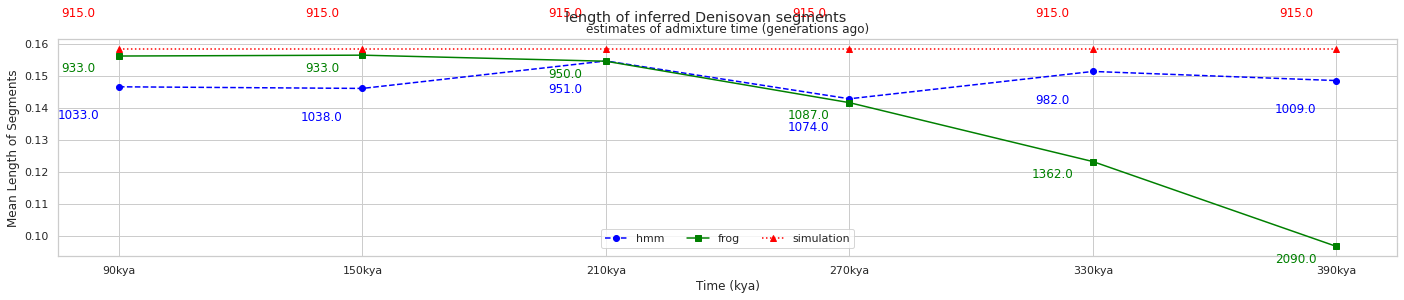

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

s = "den"

    
#fig, axes = plt.subplots(1, 6, figsize=(24, 4), sharex=True, sharey=True)
fig, axes = plt.subplots(1, 1, figsize=(24, 4))
mean_hmm = []
mean_frog = []
mean_sim = []
time_s = []
mean_hmm_est = []
mean_frog_est = []
mean_sim_est = []
for panel, t in zip(range(0,6), ['90','150','210','270','330', '390']):
    time_s.append(int(t))

    #sensi 
    # hit + hit_wrong > hit_all, as hit_all does not include overlapping part in a  diploid genome, but hit wrong can are hap.
    len_frog_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.0", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_1 = len_frog_1[['len','source','method','ind','chr','start','end']]
    len_frog_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.1", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_2 = len_frog_2[['len','source','method','ind','chr','start','end']]
    len_frog_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.2", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_3 = len_frog_3[['len','source','method','ind','chr','start','end']]
    len_hmm_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.0", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_1 = len_hmm_1[['len','s1','chr','start','end']]
    len_hmm_1['source'] = len_hmm_1['s1'].str[:3]
    len_hmm_1['method'] = "hmm"
    len_hmm_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.1", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_2 = len_hmm_2[['len','s1','chr','start','end']]
    len_hmm_2['source'] = len_hmm_2['s1'].str[:3]
    len_hmm_2['method'] = "hmm"
    len_hmm_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.2", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_3 = len_hmm_3[['len','s1','chr','start','end']]
    len_hmm_3['source'] = len_hmm_3['s1'].str[:3]
    len_hmm_3['method'] = "hmm"
    len_true_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.0", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_1['len'] = (len_true_1['end'] - len_true_1['start']) *1.25e-6
    len_true_1 = len_true_1[['len','source','ind','chr','start','end']]
    len_true_1['method'] = "simulation"
    len_true_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.1", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_2['len'] = (len_true_2['end'] - len_true_2['start']) *1.25e-6
    len_true_2 = len_true_2[['len','source','ind','chr','start','end']]
    len_true_2['method'] = "simulation"
    len_true_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.2", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_3['len'] = (len_true_3['end'] - len_true_3['start']) *1.25e-6
    len_true_3 = len_true_3[['len','source','ind','chr','start','end']]
    len_true_3['method'] = "simulation"
    len_1 = pd.concat([len_frog_1,len_hmm_1,len_true_1])
    len_2 = pd.concat([len_frog_2,len_hmm_2,len_true_2])
    len_3 = pd.concat([len_frog_3,len_hmm_3,len_true_3])

    sns.set(style="whitegrid")


    colors = {'AA': 'red', 'd3_AA': 'red','den_AA':'red', 'd3':"pink", 'den': 'pink', 'hmm': 'blue'}
    shapes = {'AA': 'o', 'd3_AA':'s','den_AA':'D', 'd3': 's', 'den': 'D', 'hmm': '^'}
    linestyles = {3: 'dashdot', 4: 'dashed', 5: 'dotted', 6: 'solid'}
    lens = [len_1, len_2, len_3]
    handles, labels = [], []
    #for xxx, df2, s_time in zip(range(0,3), lens, ['30kya','15kya','0kya']):
    df2 = lens[1]
    s_time = "15kya"
    if s == "den":
        df2 = df2[(df2['source']=="den") | (df2['source']=="d3")]
    else:
        df2 = df2[(df2['source']=="nea")]    
    hmm = df2[df2['method'] == 'hmm']
    frog = df2[df2['method'] == 'den_AA']
    sim = df2[df2['method'] == 'simulation']
    # Calculate histogram data for each dataframe
    # Plot bar charts for each histogram
    tdf = pd.DataFrame(columns = ['len','mean','time','method'])
    tm = hmm.rename(columns={'len': 'length_cM'})
    result = Simple_Pulse_Segments_fn(input_df=tm, truncation=True, lower_trunc=0.05, upper_trunc=tm['length_cM'].max(), tm_lower=10, tm_upper=5000)
    tt = round(result['params_df']['tm'][0],0)
    mean_hmm_est.append(tt)
    mean = hmm[hmm['len']>=0.05]['len'].mean()
    mean_hmm.append(mean)
    tdf = pd.concat([tdf,pd.DataFrame({'len':[tt],'mean':[mean],'time':[tt],'method':['hmm']})])
    tm = frog.rename(columns={'len': 'length_cM'})
    result = Simple_Pulse_Segments_fn(input_df=tm, truncation=True, lower_trunc=0.05, upper_trunc=tm['length_cM'].max(), tm_lower=10, tm_upper=5000)
    tt = round(result['params_df']['tm'][0],0)
    mean_frog_est.append(tt)
    mean = frog[frog['len']>=0.05]['len'].mean()
    mean_frog.append(mean)
    tdf = pd.concat([tdf,pd.DataFrame({'len':[tt],'mean':[mean],'time':[tt],'method':['frog']})])
    tm = sim.rename(columns={'len': 'length_cM'})
    result = Simple_Pulse_Segments_fn(input_df=tm, truncation=True, lower_trunc=0.05, upper_trunc=tm['length_cM'].max(), tm_lower=10, tm_upper=5000)
    tt = round(result['params_df']['tm'][0],0)
    mean_sim_est.append(tt)
    mean = sim[sim['len']>=0.05]['len'].mean()
    mean_sim.append(mean)
    # tdf = pd.concat([tdf,pd.DataFrame({'len':[tt],'mean':[mean],'time':[tt],'method':['simulation']})])
    # for i, group in enumerate(['hmm','frog','simulation']):
    #     # Filter the DataFrame for each group
    #     group_data = tdf[tdf['method'] == group]
    #     test = round(group_data['time'][0])
    #     axes[panel].bar(i, group_data['mean'],label='0')
    #     axes[panel].text(i, group_data['mean'], f'{test} g', ha='center')
    #     print(f"{group}, {tt}, {t}, {mean}")
    #     axes[panel].set_title(f'{t}ky Den divergence')
    # axes[panel].set_xticks(range(3))  # Positions of the ticks (0, 1, 2)
    # axes[panel].set_xticklabels(['hmm','frog','simulation']) 
    # #lgd = fig.legend(handles[0:3], labels[0:5], loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)
axes.plot(time_s, mean_hmm, label='hmm', marker='o', color='blue', linestyle='--')
axes.plot(time_s, mean_frog, label='frog', marker='s', color='green', linestyle='-')
axes.plot(time_s, mean_sim, label='simulation', marker='^', color='red', linestyle=':')
axes.set_xticks(time_s)
axes.set_xticklabels([f'{tp}kya' for tp in time_s])  # This will display "90kya", "150kya", etc. on the x-axis
# Add labels and titles
modified_time_points = [int(x) - 10 for x in time_s]
for i, (x, y_hmm, y_frog, y_sim) in enumerate(zip(modified_time_points, mean_hmm, mean_frog, mean_sim)):
    # Add text for 'hmm'
    axes.text(x, y_hmm - 0.01, f'{mean_hmm_est[i]}', color='blue', ha='center')
    # Add text for 'frog'
    axes.text(x, y_frog -0.005, f'{mean_frog_est[i]}', color='green', ha='center')
    # Add text for 'simulation'
    axes.text(x, y_sim + 0.01, f'{mean_sim_est[i]}', color='red', ha='center')
axes.legend(loc='upper center', bbox_to_anchor=(0.5, 0.15), ncol=3)
axes.set_xlabel('Time (kya)')
axes.set_ylabel('Mean Length of Segments')
axes.set_title(f'estimates of admixture time (generations ago)')

if s == "nea":
    fig.suptitle(f"length of inferred Neanderthal segments")
elif s == "den":
    fig.suptitle(f"length of inferred Denisovan segments")
    
# Show the plot
plt.show()


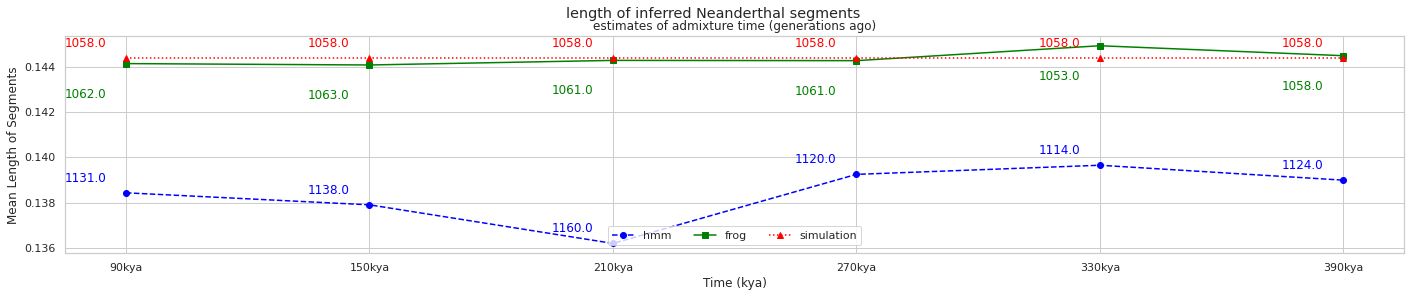

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

s = "nea"

    
#fig, axes = plt.subplots(1, 6, figsize=(24, 4), sharex=True, sharey=True)
fig, axes = plt.subplots(1, 1, figsize=(24, 4))
mean_hmm = []
mean_frog = []
mean_sim = []
time_s = []
mean_hmm_est = []
mean_frog_est = []
mean_sim_est = []
for panel, t in zip(range(0,6), ['90','150','210','270','330', '390']):
    time_s.append(int(t))

    #sensi 
    # hit + hit_wrong > hit_all, as hit_all does not include overlapping part in a  diploid genome, but hit wrong can are hap.
    len_frog_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.0", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_1 = len_frog_1[['len','source','method','ind','chr','start','end']]
    len_frog_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.1", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_2 = len_frog_2[['len','source','method','ind','chr','start','end']]
    len_frog_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.frog_call.2", names = ['chr','start','end','len','source','method','ind'], sep = '\s+')
    len_frog_3 = len_frog_3[['len','source','method','ind','chr','start','end']]
    len_hmm_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.0", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_1 = len_hmm_1[['len','s1','chr','start','end']]
    len_hmm_1['source'] = len_hmm_1['s1'].str[:3]
    len_hmm_1['method'] = "hmm"
    len_hmm_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.1", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_2 = len_hmm_2[['len','s1','chr','start','end']]
    len_hmm_2['source'] = len_hmm_2['s1'].str[:3]
    len_hmm_2['method'] = "hmm"
    len_hmm_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.posterior.called.anno.2", names = ['chr','start','end','pos_len','len','m1','m2','m3','m4','m5','s1','s2','m','source','ind'], sep = '\s+')
    len_hmm_3 = len_hmm_3[['len','s1','chr','start','end']]
    len_hmm_3['source'] = len_hmm_3['s1'].str[:3]
    len_hmm_3['method'] = "hmm"
    len_true_1 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.0", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_1['len'] = (len_true_1['end'] - len_true_1['start']) *1.25e-6
    len_true_1 = len_true_1[['len','source','ind','chr','start','end']]
    len_true_1['method'] = "simulation"
    len_true_2 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.1", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_2['len'] = (len_true_2['end'] - len_true_2['start']) *1.25e-6
    len_true_2 = len_true_2[['len','source','ind','chr','start','end']]
    len_true_2['method'] = "simulation"
    len_true_3 = pd.read_csv(f"sim/D_{t}/sum_stats_missing/ea.true.bed.2", names = ['chr','start','end','source','ind'], sep = '\s+')
    len_true_3['len'] = (len_true_3['end'] - len_true_3['start']) *1.25e-6
    len_true_3 = len_true_3[['len','source','ind','chr','start','end']]
    len_true_3['method'] = "simulation"
    len_1 = pd.concat([len_frog_1,len_hmm_1,len_true_1])
    len_2 = pd.concat([len_frog_2,len_hmm_2,len_true_2])
    len_3 = pd.concat([len_frog_3,len_hmm_3,len_true_3])

    sns.set(style="whitegrid")


    colors = {'AA': 'red', 'd3_AA': 'red','den_AA':'red', 'd3':"pink", 'den': 'pink', 'hmm': 'blue'}
    shapes = {'AA': 'o', 'd3_AA':'s','den_AA':'D', 'd3': 's', 'den': 'D', 'hmm': '^'}
    linestyles = {3: 'dashdot', 4: 'dashed', 5: 'dotted', 6: 'solid'}
    lens = [len_1, len_2, len_3]
    handles, labels = [], []
    #for xxx, df2, s_time in zip(range(0,3), lens, ['30kya','15kya','0kya']):
    df2 = lens[1]
    s_time = "15kya"
    if s == "den":
        df2 = df2[(df2['source']=="den") | (df2['source']=="d3")]
    else:
        df2 = df2[(df2['source']=="nea")]    
    hmm = df2[df2['method'] == 'hmm']
    frog = df2[df2['method'] == 'den_AA']
    sim = df2[df2['method'] == 'simulation']
    # Calculate histogram data for each dataframe
    # Plot bar charts for each histogram
    tdf = pd.DataFrame(columns = ['len','mean','time','method'])
    tm = hmm.rename(columns={'len': 'length_cM'})
    result = Simple_Pulse_Segments_fn(input_df=tm, truncation=True, lower_trunc=0.05, upper_trunc=tm['length_cM'].max(), tm_lower=10, tm_upper=5000)
    tt = round(result['params_df']['tm'][0],0)
    mean_hmm_est.append(tt)
    mean = hmm[hmm['len']>=0.05]['len'].mean()
    mean_hmm.append(mean)
    tdf = pd.concat([tdf,pd.DataFrame({'len':[tt],'mean':[mean],'time':[tt],'method':['hmm']})])
    tm = frog.rename(columns={'len': 'length_cM'})
    result = Simple_Pulse_Segments_fn(input_df=tm, truncation=True, lower_trunc=0.05, upper_trunc=tm['length_cM'].max(), tm_lower=10, tm_upper=5000)
    tt = round(result['params_df']['tm'][0],0)
    mean_frog_est.append(tt)
    mean = frog[frog['len']>=0.05]['len'].mean()
    mean_frog.append(mean)
    tdf = pd.concat([tdf,pd.DataFrame({'len':[tt],'mean':[mean],'time':[tt],'method':['frog']})])
    tm = sim.rename(columns={'len': 'length_cM'})
    result = Simple_Pulse_Segments_fn(input_df=tm, truncation=True, lower_trunc=0.05, upper_trunc=tm['length_cM'].max(), tm_lower=10, tm_upper=5000)
    tt = round(result['params_df']['tm'][0],0)
    mean_sim_est.append(tt)
    mean = sim[sim['len']>=0.05]['len'].mean()
    mean_sim.append(mean)
    # tdf = pd.concat([tdf,pd.DataFrame({'len':[tt],'mean':[mean],'time':[tt],'method':['simulation']})])
    # for i, group in enumerate(['hmm','frog','simulation']):
    #     # Filter the DataFrame for each group
    #     group_data = tdf[tdf['method'] == group]
    #     test = round(group_data['time'][0])
    #     axes[panel].bar(i, group_data['mean'],label='0')
    #     axes[panel].text(i, group_data['mean'], f'{test} g', ha='center')
    #     print(f"{group}, {tt}, {t}, {mean}")
    #     axes[panel].set_title(f'{t}ky Den divergence')
    # axes[panel].set_xticks(range(3))  # Positions of the ticks (0, 1, 2)
    # axes[panel].set_xticklabels(['hmm','frog','simulation']) 
    # #lgd = fig.legend(handles[0:3], labels[0:5], loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)
axes.plot(time_s, mean_hmm, label='hmm', marker='o', color='blue', linestyle='--')
axes.plot(time_s, mean_frog, label='frog', marker='s', color='green', linestyle='-')
axes.plot(time_s, mean_sim, label='simulation', marker='^', color='red', linestyle=':')
axes.set_xticks(time_s)
axes.set_xticklabels([f'{tp}kya' for tp in time_s])  # This will display "90kya", "150kya", etc. on the x-axis
# Add labels and titles
modified_time_points = [int(x) - 10 for x in time_s]
for i, (x, y_hmm, y_frog, y_sim) in enumerate(zip(modified_time_points, mean_hmm, mean_frog, mean_sim)):
    # Add text for 'hmm'
    axes.text(x, y_hmm+0.0005 , f'{mean_hmm_est[i]}', color='blue', ha='center')
    # Add text for 'frog'
    axes.text(x, y_frog -0.0015, f'{mean_frog_est[i]}', color='green', ha='center')
    # Add text for 'simulation'
    axes.text(x, y_sim + 0.0005, f'{mean_sim_est[i]}', color='red', ha='center')
axes.legend(loc='upper center', bbox_to_anchor=(0.5, 0.15), ncol=3)
axes.set_xlabel('Time (kya)')
axes.set_ylabel('Mean Length of Segments')
axes.set_title(f'estimates of admixture time (generations ago)')

if s == "nea":
    fig.suptitle(f"length of inferred Neanderthal segments")
elif s == "den":
    fig.suptitle(f"length of inferred Denisovan segments")
    
# Show the plot
plt.show()
